In [ ]:
!pip install ultralytics
!pip install cvzone
!pip install bounding-box
!pip install pybboxes
!pip install moviepy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.9/606.9 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.5.6-py3-none-any.whl size=18749 sha256=54d41775a889fda44524f638fe8c68f159d6393e2e08d0616af3ec10193d9d44
  Stored in directory: /root/.cache/pip/wheels/d8/85/f1/1756f9e009d280be742fb20dd5087c60c2f7f0279964934375
Successfully built cvzone
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.9/164.9 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bounding-box: filename=bounding_box-0.1.3-py3-none-any.whl size=163919 sha256=d3dfa2f712e3faa907f59da3bf353f0f2ec226088fcd31374073d3fb3d511c4f
  Stored in directory: /root/.cache/pip/wheels/69/0e/79/6f4a3129978e90cc917310088d35ef0e711366a5a5a1c99eec
Successfully built bounding-box


In [ ]:
import sys
import cv2
import cvzone
import math
import numpy as np
import torch
from PIL import Image
from pathlib import Path
from collections import Counter,OrderedDict
from pybboxes import BoundingBox
import os
import subprocess
from moviepy.editor import VideoFileClip, ImageClip
import re
from torchvision import transforms
from ultralytics import YOLO
# from utils.datasets import LoadImages  # Import the appropriate dataset loader
# from models import YOLOv7
print(f"Python version: {sys.version}, {sys.version_info} ")
print(f"Pytorch version: {torch.__version__} ")

Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0], sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0) 
Pytorch version: 2.0.1+cu118 


In [ ]:
!rm -rf /content/runs/detect
!rm -rf /content/images

In [ ]:
def video_to_images(video_path, output_folder, frame_rate=10):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Open the video file
    clip = VideoFileClip(video_path)

    # Get video properties
    fps = clip.fps
    total_frames = int(clip.duration * fps)
    frame_interval = int(fps / frame_rate)

    for frame_index in range(0, total_frames, frame_interval):
        # Get the frame at the specified time
        frame = clip.get_frame(frame_index / fps)

        # Save the frame as an image file using MoviePy
        image_path = os.path.join(output_folder, f"frame_{frame_index}.jpg")
        frame_image = ImageClip(frame)
        frame_image.save_frame(image_path, t=frame_index / fps)

    # Close the video clip
    clip.reader.close()
    clip.audio.reader.close_proc()





In [ ]:
video_path = "/content/yolo_trial.mp4"

video_to_images(video_path, "/content/images")


In [ ]:
def imShow(path):
    import cv2
    import matplotlib.pyplot as plt

    image = cv2.imread(path)

    if image is not None:
        height, width = image.shape[:2]
        resized_image = cv2.resize(image, (3*width, 3*height), interpolation=cv2.INTER_CUBIC)

        plt.figure(figsize=(18, 10))
        plt.axis("off")
        plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("Failed to load the image.")



In [ ]:
classnames = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck',
              'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
              'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
              'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
              'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
              'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork',
              'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
              'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant',
              'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote',
              'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
              'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
from ultralytics import YOLO
import sys

model = YOLO('yolov8n.pt')  # pretrained YOLOv8n model

image_directory = "/content/images"
image_files = [file for file in os.listdir(image_directory) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]
image_files = image_files[:4] # just to make runtime less if needed could remove later


100%|██████████| 6.23M/6.23M [00:00<00:00, 102MB/s]


In [ ]:
from contextlib import redirect_stdout

def get_classes(image_directory,image_file):
  results = [0]*len(classnames)
  image_path = os.path.join(image_directory, image_file)
  with open(os.devnull, 'w') as dummy_output:
    with redirect_stdout(dummy_output):
      result = model.predict(image_path, save=True, save_txt=True)

  labels_path = "/content/runs/detect/predict/labels"
  final_image = "/content/runs/detect/predict/"
  final_image = os.path.join(final_image,image_file)
  image_name = image_file.split('.')[0]
  label_file = os.path.join(labels_path,f"{image_name}.txt")
  with open(label_file, 'r') as file:
    for line in file:
      line = line.strip()
      label = line.split()[0]
      label = int(label)
      results[label] += 1

  final = {}
  for i in range(len(results)):
    if(results[i] != 0):
      final.update({classnames[i]:results[i]})

  return final_image,final

In [ ]:
final_results = {}
for image_file in image_files:
  image_path = os.path.join(image_directory, image_file)
  # model.predict(image_path,save=True,save_txt=True)
  image_path,classes = get_classes(image_directory,image_file)
  final_results.update({image_path:classes})



image 1/1 /content/images/frame_186.jpg: 384x640 14 persons, 3 cars, 2 trucks, 410.0ms
Speed: 27.6ms preprocess, 410.0ms inference, 36.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels

image 1/1 /content/images/frame_124.jpg: 384x640 12 persons, 2 buss, 178.5ms
Speed: 6.1ms preprocess, 178.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
2 labels saved to runs/detect/predict/labels

image 1/1 /content/images/frame_278.jpg: 384x640 1 bus, 158.7ms
Speed: 3.5ms preprocess, 158.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
3 labels saved to runs/detect/predict/labels

image 1/1 /content/images/frame_50.jpg: 384x640 7 persons, 5 cars, 2 buss, 1 truck, 152.7ms
Speed: 10.3ms preprocess, 152.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict

{
    "/content/runs/detect/predict/frame_186.jpg": {
        "person": 14,
        "car": 3,
        "truck": 2
    },
    "/content/runs/detect/predict/frame_124.jpg": {
        "person": 12,
        "bus": 2
    },
    "/content/runs/detect/predict/frame_278.jpg": {
        "bus": 1
    },
    "/content/runs/detect/predict/frame_50.jpg": {
        "person": 7,
        "car": 5,
        "bus": 2,
        "truck": 1
    }
}


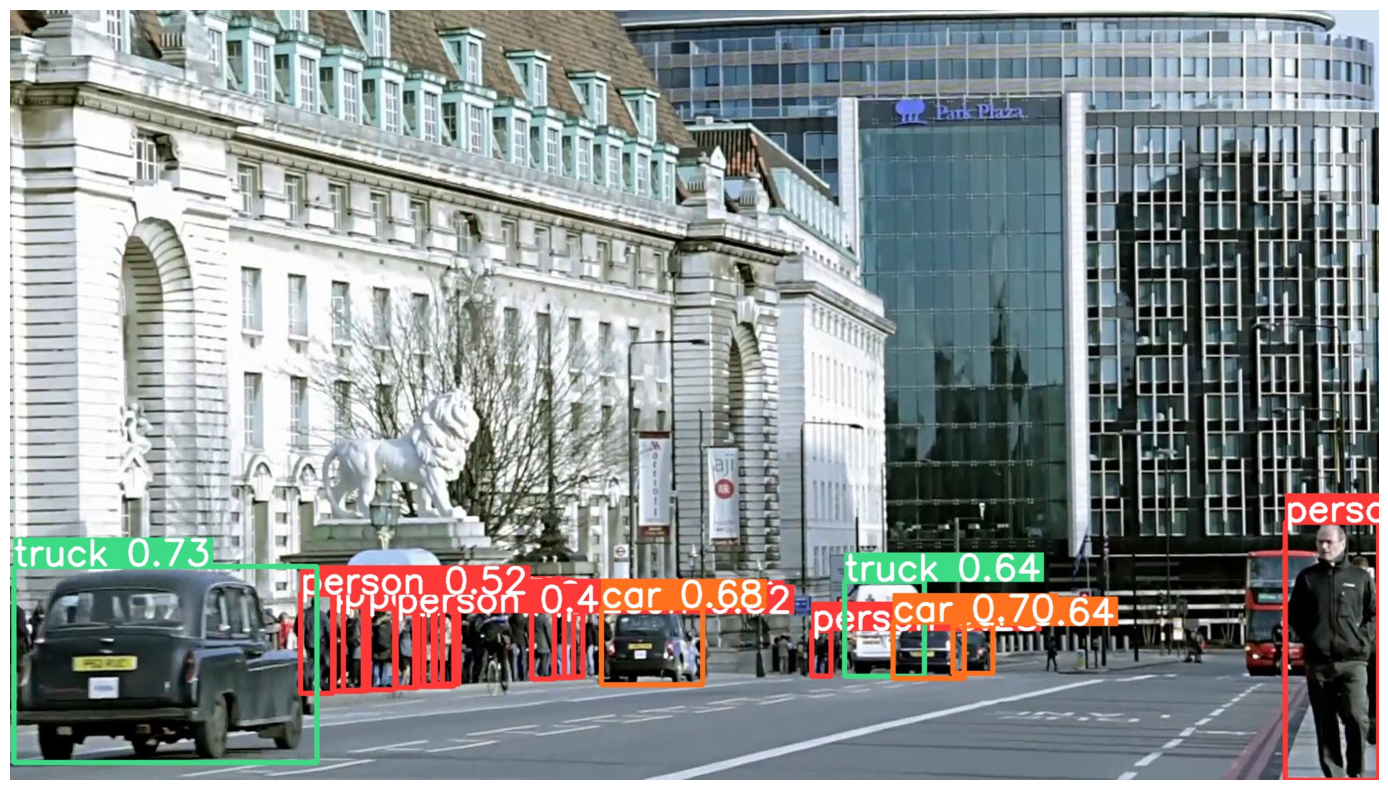

{'person': 14, 'car': 3, 'truck': 2}


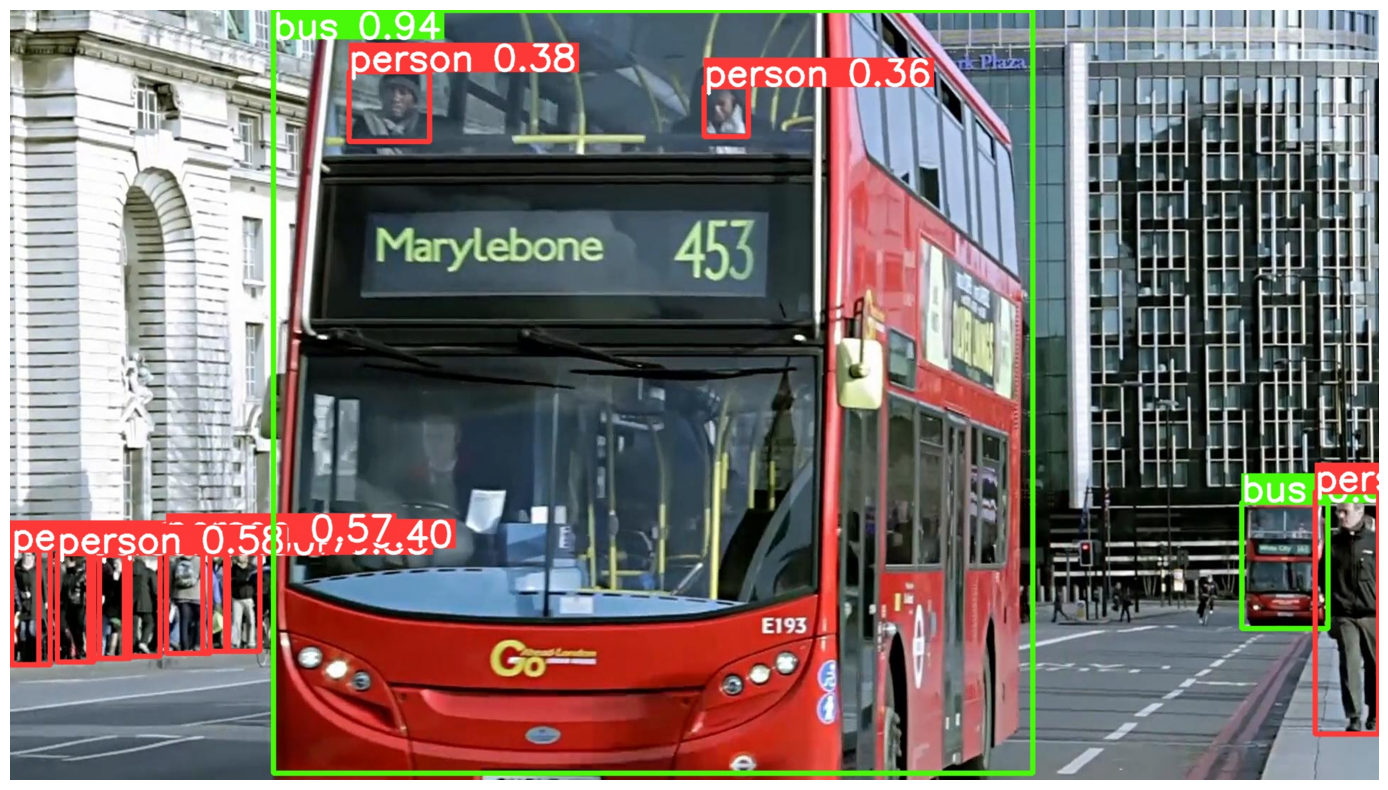

{'person': 12, 'bus': 2}


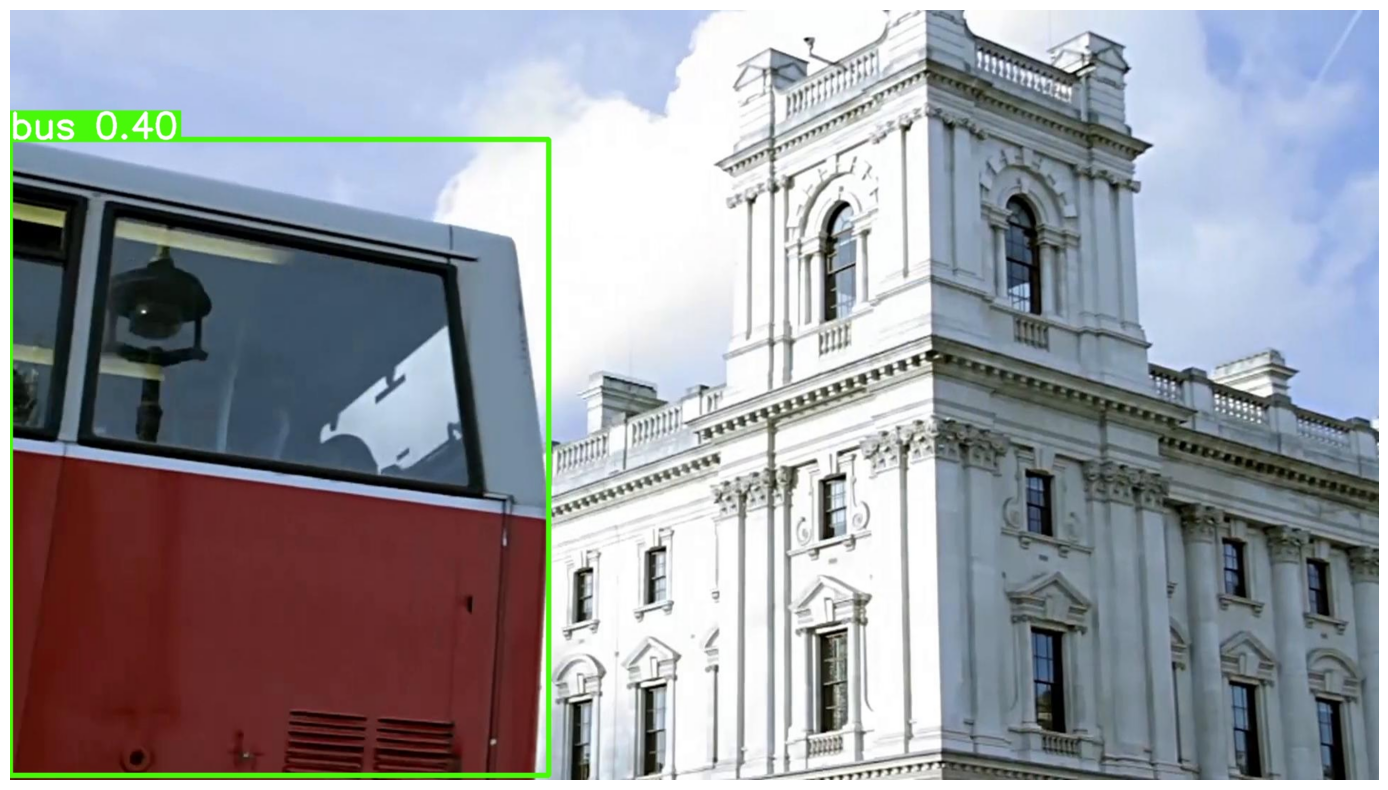

{'bus': 1}


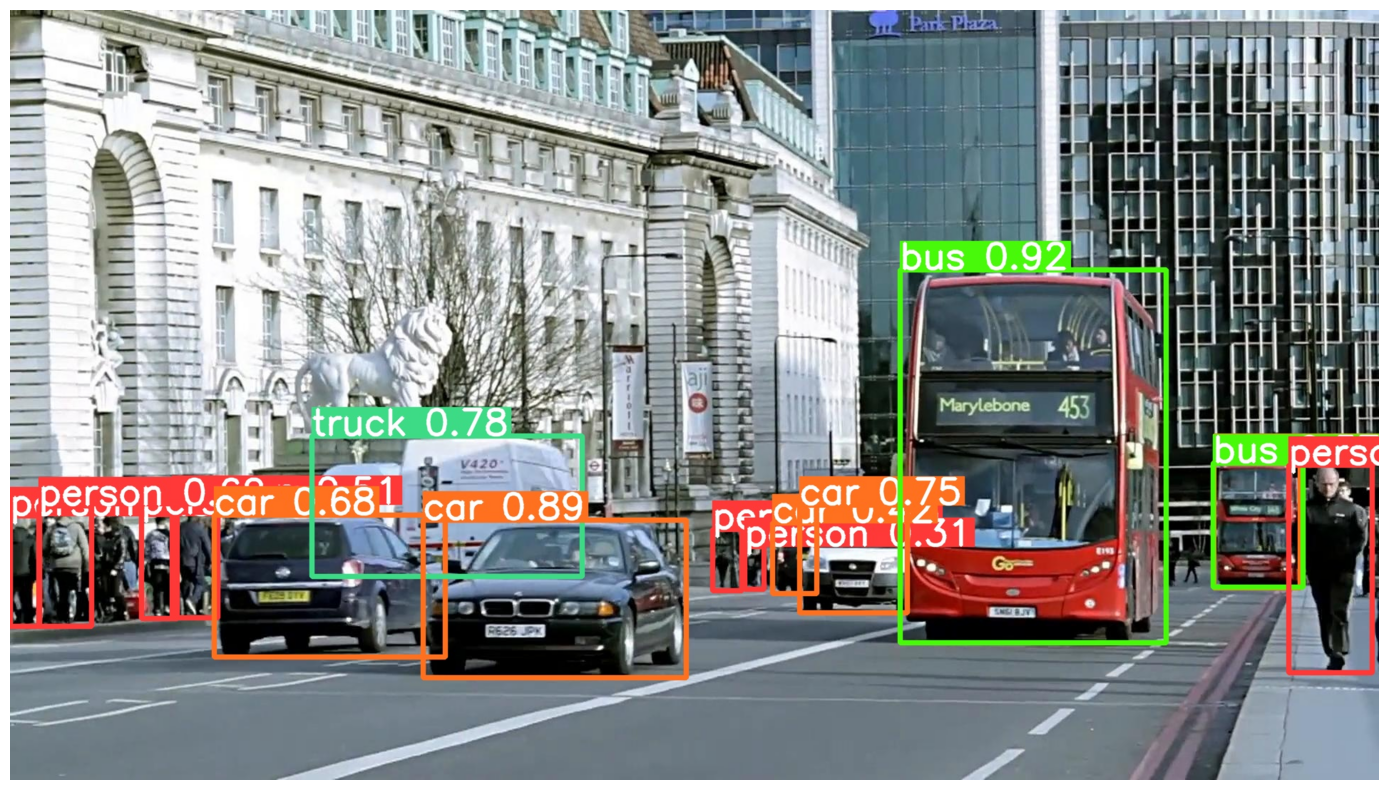

{'person': 7, 'car': 5, 'bus': 2, 'truck': 1}


In [ ]:
import json

formatted_output = json.dumps(final_results, indent=4)

# Print the formatted output
print(formatted_output)

for key in final_results.keys():
  imShow(key)
  print(final_results[key])

!rm -rf /content/runs/detect


In [ ]:
import cv2
import os

image_folder = 'path_to_output_images'
video_name = 'output_video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
images.sort()

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 15, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()


FileNotFoundError: ignored